A demo training script for training the H-network.

Grab the dataset first

We create a dataset, in which the user's load $y_t$ is loaded from the split aggregate_df dataset  
Then we generate the load received from the grid $z_t$ as a function of $y_t$ and random Gaussian noise $b$ (to represent the battery charging/discharging rate), i.e. $z_t = y_t + b, \quad b \sim \mathcal{N}(0, I)$

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250703", "split")

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
aggregate_load_segments, aggregate_load_df = load_split_data_from_folder(dataset_folder_path, 'train')

In [6]:
aggregate_load_df

,timestamp,aggregate,datetime,washing_machine,dishwasher,fridge,kettle,microwave,toaster,tv,htpc,gas_oven,kitchen_lights
0,1.356998e+09,499.0,2013-01-01 00:00:01+00:00,0.0,1.0,89.0,1.0,1.0,0.0,89.0,69.0,NaN,0.0
1,1.356998e+09,500.0,2013-01-01 00:00:07+00:00,0.0,1.0,89.0,1.0,1.0,0.0,89.0,69.0,NaN,0.0
2,1.356998e+09,515.0,2013-01-01 00:00:13+00:00,0.0,1.0,88.0,1.0,1.0,0.0,125.0,70.0,NaN,0.0
3,1.356998e+09,522.0,2013-01-01 00:00:19+00:00,0.0,1.0,89.0,1.0,1.0,0.0,91.0,70.0,NaN,0.0
4,1.356998e+09,508.0,2013-01-01 00:00:26+00:00,0.0,1.0,89.0,1.0,1.0,0.0,93.0,69.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462393,1.388448e+09,178.0,2013-12-30 23:59:35+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2462394,1.388448e+09,177.0,2013-12-30 23:59:41+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2462395,1.388448e+09,178.0,2013-12-30 23:59:47+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2462396,1.388448e+09,178.0,2013-12-30 23:59:53+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0


In [7]:
aggregate_load_segments

[(datetime.datetime(2013, 1, 12, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 12, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 18, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 18, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 20, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 20, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 24, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 24, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 6, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 2, 1, 0, 0, tzinfo=datetime.timezone.utc),
  da

In [8]:
# break the segments into per-day segments
def break_segments_into_days(segments):
    """Break segments into per-day segments"""
    daily_segments = []
    for start, end in segments:
        current = start
        while current < end:
            next_day = current + timedelta(days=1) - timedelta(milliseconds=1)
            daily_segments.append((current, min(next_day, end)))
            current = next_day + timedelta(milliseconds=1)
    return daily_segments

daily_segments = break_segments_into_days(aggregate_load_segments)

daily_segments

[(datetime.datetime(2013, 1, 12, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 12, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 18, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 18, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 20, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 20, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 24, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 24, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 8, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 9, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 9, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 10, 0, 0, tzinfo=datetime.timezone.utc),
  da

In [9]:
# extract the daily aggregate load data from the dataframe
def create_24_hour_sequences(aggregate_load_df, segments):
    """Create 24-hour sequences from aggregate load data"""
    sequences = []
    for start, end in segments:
        day_data = aggregate_load_df[(aggregate_load_df['datetime'] >= start) & (aggregate_load_df['datetime'] <= end)]

        # only keep the timestamp, aggregate, datetime columns
        day_data = day_data[['timestamp', 'aggregate', 'datetime']]

        if not day_data.empty:
            sequences.append(day_data)
    return sequences

daily_sequences = create_24_hour_sequences(aggregate_load_df, daily_segments)

In [10]:
# for each daily sequence, comnpute the load received from the grid
np.random.seed(20250706)  # for reproducibility

def compute_load_received_from_grid(daily_sequences, noise_std=0.1):
    """Compute load received from the grid for each daily sequence"""
    grid_loads = []
    for seq in daily_sequences:
        # generate random noise
        noise = np.random.normal(0, noise_std, len(seq))
        # compute load received from the grid

        grid_load = seq['aggregate'] + noise
        # ensure non-negative grid load
        seq['grid_load'] = grid_load.clip(lower=0)
        grid_loads.append(seq)
    return grid_loads

daily_sequences = compute_load_received_from_grid(daily_sequences)

Construct input and (targetted) output of the H-network

Input:  
For each episode:  
Input sequence: $( [y_0, y_1, ..., y_{T-1}], [z_0, z_1, ..., z_{T-1}] )$ (possibly concatenated per time step)  
Target:  
For each episode:  
Target sequence: $( [y_1, y_2, ..., y_T] )$ (the next-step user load at each time step)  

In [11]:
daily_sequences[1]

,timestamp,aggregate,datetime,grid_load
93578,1.357690e+09,179.0,2013-01-09 00:00:04+00:00,178.859698
93579,1.357690e+09,176.0,2013-01-09 00:00:10+00:00,176.039983
93580,1.357690e+09,177.0,2013-01-09 00:00:16+00:00,177.079653
93581,1.357690e+09,175.0,2013-01-09 00:00:23+00:00,174.779029
93582,1.357690e+09,177.0,2013-01-09 00:00:29+00:00,176.862363
...,...,...,...,...
106956,1.357776e+09,311.0,2013-01-09 23:59:25+00:00,310.821487
106957,1.357776e+09,305.0,2013-01-09 23:59:37+00:00,304.975486
106958,1.357776e+09,310.0,2013-01-09 23:59:43+00:00,310.001421
106959,1.357776e+09,309.0,2013-01-09 23:59:49+00:00,309.034510


In [12]:
# compute mean length of the sequences
mean_length = np.mean([len(seq) for seq in daily_sequences])
mean_length

13679.988888888889

Perform data preprocessing (standardization & normalization) for each daily sequence  
before creating input & target sequences for the H-network

In [13]:
# perform data preprocessing (standardization)
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()

scaler_train = scaler_train.fit(aggregate_load_df[['aggregate']].values)

def preprocess_daily_sequences(daily_sequences, scaler):
    """Preprocess daily sequences using the provided scaler"""
    for seq in daily_sequences:
        # standardize the aggregate load
        seq['aggregate'] = scaler.transform(seq[['aggregate']].values)

        seq['grid_load'] = scaler.transform(seq[['grid_load']].values)

preprocess_daily_sequences(daily_sequences, scaler_train)

In [14]:
daily_sequences[1]

,timestamp,aggregate,datetime,grid_load
93578,1.357690e+09,-0.413775,2013-01-09 00:00:04+00:00,-0.414127
93579,1.357690e+09,-0.421301,2013-01-09 00:00:10+00:00,-0.421200
93580,1.357690e+09,-0.418792,2013-01-09 00:00:16+00:00,-0.418592
93581,1.357690e+09,-0.423809,2013-01-09 00:00:23+00:00,-0.424364
93582,1.357690e+09,-0.418792,2013-01-09 00:00:29+00:00,-0.419137
...,...,...,...,...
106956,1.357776e+09,-0.082631,2013-01-09 23:59:25+00:00,-0.083079
106957,1.357776e+09,-0.097683,2013-01-09 23:59:37+00:00,-0.097745
106958,1.357776e+09,-0.085140,2013-01-09 23:59:43+00:00,-0.085137
106959,1.357776e+09,-0.087649,2013-01-09 23:59:49+00:00,-0.087562


In [15]:
# create input and target sequences for the H-network
def create_h_network_sequences(daily_sequences):
    """Create input and target sequences for the H-network"""
    input_sequences = []
    target_sequences = []
    
    for seq in daily_sequences:
        # input sequence: [z_0, z_1, ..., z_{T-1}], [y_0, y_1, ..., y_{T-1}]
        input_seq = np.column_stack((seq['grid_load'].values[:-1], seq['aggregate'].values[:-1]))
        
        # target sequence: [y_1, y_2, ..., y_T]
        target_seq = seq['aggregate'].values[1:]
        
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
    
    return list(input_sequences), list(target_sequences)        # since each seq has different length, we return lists instead of numpy arrays

input_sequences, target_sequences = create_h_network_sequences(daily_sequences)

Compute padding & masking, and chunking the sequence into 512 length.

Chunk the sequence using sparse-separated rolling windows, e.g. with stride = 512/8 = 64

In [16]:
import torch

def chunk_pad_mask_sequences(input_sequences, target_sequences, chunk_size=512, stride=64, padding_value=0.0):
    """
    Chunk, pad, and mask input/target sequences for LSTM training.
    Args:
        input_sequences: list of np.ndarray, each shape (T, 2)
        target_sequences: list of np.ndarray, each shape (T,)
        chunk_size: int, length of each chunk
        stride: int, step size for rolling window
        padding_value: value to use for padding
    Returns:
        padded_inputs: torch.Tensor, shape (N, chunk_size, 2)
        padded_targets: torch.Tensor, shape (N, chunk_size)
        mask: torch.BoolTensor, shape (N, chunk_size)
    """
    chunked_inputs = []
    chunked_targets = []
    chunked_masks = []

    for inp_seq, tgt_seq in zip(input_sequences, target_sequences):
        seq_len = inp_seq.shape[0]
        # Rolling window chunking
        for start in range(0, seq_len, stride):
            end = start + chunk_size
            inp_chunk = inp_seq[start:end]
            tgt_chunk = tgt_seq[start:end]
            mask = np.zeros(chunk_size, dtype=bool)
            valid_len = min(chunk_size, seq_len - start)
            mask[:valid_len] = True
            # Pad if needed
            if inp_chunk.shape[0] < chunk_size:
                pad_len = chunk_size - inp_chunk.shape[0]
                inp_chunk = np.pad(inp_chunk, ((0, pad_len), (0, 0)), mode='constant', constant_values=padding_value)
                tgt_chunk = np.pad(tgt_chunk, (0, pad_len), mode='constant', constant_values=padding_value)
            chunked_inputs.append(torch.tensor(inp_chunk, dtype=torch.float32))
            chunked_targets.append(torch.tensor(tgt_chunk, dtype=torch.float32))
            chunked_masks.append(torch.tensor(mask, dtype=torch.bool))
            # Stop if we've reached the end
            if end >= seq_len:
                break

    padded_inputs = torch.stack(chunked_inputs)
    padded_targets = torch.stack(chunked_targets)
    mask = torch.stack(chunked_masks)
    return padded_inputs, padded_targets, mask

# Example usage:
padded_inputs, padded_targets, mask = chunk_pad_mask_sequences(input_sequences, target_sequences, chunk_size=512, stride=64)
print(f"padded_inputs shape: {padded_inputs.shape}")
print(f"padded_targets shape: {padded_targets.shape}")
print(f"mask shape: {mask.shape}")

padded_inputs shape: torch.Size([37306, 512, 2])
padded_targets shape: torch.Size([37306, 512])
mask shape: torch.Size([37306, 512])


Perform the same data processing for test dataset and validation dataset

In [17]:
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test')
daily_segments_test = break_segments_into_days(aggregate_load_segments_test)
daily_sequences_test = create_24_hour_sequences(aggregate_load_df_test, daily_segments_test)
daily_sequences_test = compute_load_received_from_grid(daily_sequences_test)
daily_segments_test = preprocess_daily_sequences(daily_sequences_test, scaler_train)
input_sequences_test, target_sequences_test = create_h_network_sequences(daily_sequences_test)
padded_inputs_test, padded_targets_test, mask_test = chunk_pad_mask_sequences(input_sequences_test, target_sequences_test, chunk_size=512, stride=64)
print(f"padded_inputs_test shape: {padded_inputs_test.shape}")
print(f"padded_targets_test shape: {padded_targets_test.shape}")
print(f"mask_test shape: {mask_test.shape}")

padded_inputs_test shape: torch.Size([13236, 512, 2])
padded_targets_test shape: torch.Size([13236, 512])
mask_test shape: torch.Size([13236, 512])


In [18]:
aggregate_load_segments_valid, aggregate_load_df_valid = load_split_data_from_folder(dataset_folder_path, 'val')
daily_segments_valid = break_segments_into_days(aggregate_load_segments_valid)
daily_sequences_valid = create_24_hour_sequences(aggregate_load_df_valid, daily_segments_valid)
daily_sequences_valid = compute_load_received_from_grid(daily_sequences_valid)
daily_segments_valid = preprocess_daily_sequences(daily_sequences_valid, scaler_train)
input_sequences_valid, target_sequences_valid = create_h_network_sequences(daily_sequences_valid)
padded_inputs_valid, padded_targets_valid, mask_valid = chunk_pad_mask_sequences(input_sequences_valid, target_sequences_valid, chunk_size=512, stride=64)
print(f"padded_inputs_valid shape: {padded_inputs_valid.shape}")
print(f"padded_targets_valid shape: {padded_targets_valid.shape}")
print(f"mask_valid shape: {mask_valid.shape}")

padded_inputs_valid shape: torch.Size([15127, 512, 2])
padded_targets_valid shape: torch.Size([15127, 512])
mask_valid shape: torch.Size([15127, 512])


Initialize the H-network model

In [19]:
from model.H_network.h_network import HNetwork
import torchinfo

# Initialize the H-network model
h_network = HNetwork(input_dim=2, hidden_dim=44, output_dim=1)

# Print model summary
torchinfo.summary(h_network, input_data=padded_inputs[:1], col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
HNetwork (HNetwork)                      [1, 512, 2]          [1, 512]             --                   True
├─LSTM (LSTM_1)                          [1, 512, 2]          [1, 512, 88]         16,896               True
├─Tanh (ac1)                             [1, 512, 88]         [1, 512, 88]         --                   --
├─LSTM (LSTM_2)                          [1, 512, 88]         [1, 512, 2]          728                  True
├─Tanh (ac2)                             [1, 512, 2]          [1, 512, 2]          --                   --
├─Linear (fc)                            [1, 512, 2]          [1, 512, 1]          3                    True
Total params: 17,627
Trainable params: 17,627
Non-trainable params: 0
Total mult-adds (M): 9.02
Input size (MB): 152.81
Forward/backward pass size (MB): 0.37
Params size (MB): 0.07
Estimated Total Size (MB): 153.25

Create dataloader for training from the processed sequences

In [20]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(padded_inputs, padded_targets)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create dataloader for validation
valid_dataset = TensorDataset(padded_inputs_valid, padded_targets_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Create dataloader for test
test_dataset = TensorDataset(padded_inputs_test, padded_targets_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Declare loss function and optimizer

In [21]:
import torch.nn as nn

# Declare loss function and optimizer
# loss function is cross-entropy loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.GaussianNLLLoss()  # using Gaussian NLL loss for mean and log_variance outputs
optimizer = torch.optim.Adam(h_network.parameters(), lr=0.001)      # use Adam instead of RMSProp for better convergence

In [22]:
from model.early_stopper import EarlyStopper

# Initialize early stopper
early_stopper = EarlyStopper(patience=5, verbose=True, delta=0.001)

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

h_network.to(DEVICE)

HNetwork(
  (LSTM_1): LSTM(2, 44, batch_first=True, bidirectional=True)
  (ac1): Tanh()
  (LSTM_2): LSTM(88, 1, batch_first=True, bidirectional=True)
  (ac2): Tanh()
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [24]:
from utils import print_log
from tqdm import tqdm

# training loop
target_num_epochs = 200
executed_epochs = 0

train_loss_list = []
valid_loss_list = []

for epoch in range(target_num_epochs):

    avg_train_loss = 0.0
    h_network.train()  # set the model to training mode

    # training loop
    with tqdm(train_dataloader, desc=f"Training Epoch [{epoch+1}/{target_num_epochs}]") as tepoch:
        for batch in tepoch:
            inputs, targets = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            mean = h_network(inputs)  # get the mean
            loss = criterion(mean, targets, var=torch.ones_like(mean))  # assuming unit variance for simplicity
            loss.backward()
            optimizer.step()

            if DEVICE.type == 'cuda':
                loss = loss.cpu()
            avg_train_loss += loss.item()


            tepoch.set_postfix(loss=loss.item())
    
    
    avg_train_loss /= len(train_dataloader)
    train_loss_list.append(avg_train_loss)

    print_log(f"Epoch [{epoch+1}/{target_num_epochs}], Avg Loss: {avg_train_loss:.4f}")

    avg_valid_loss = 0.0
    h_network.eval()  # set the model to evaluation mode
    # validation loop
    with torch.no_grad():

        with tqdm(valid_dataloader, desc=f"Validating Epoch [{epoch+1}/{target_num_epochs}]") as vepoch:
            for batch in vepoch:
                inputs, targets = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                mean = h_network(inputs)
                loss = criterion(mean, targets, var=torch.ones_like(mean))  # assuming unit variance for simplicity

                if DEVICE.type == 'cuda':
                    loss = loss.cpu()
                avg_valid_loss += loss.item()

                vepoch.set_postfix(loss=loss.item())

    avg_valid_loss /= len(valid_dataloader)
    valid_loss_list.append(avg_valid_loss)

    print_log(f"Epoch [{epoch+1}/{target_num_epochs}], Avg Validation Loss: {avg_valid_loss:.4f}")

    # early stopping check
    early_stopper(avg_valid_loss, h_network)
    if early_stopper.early_stop:
        print_log("Early stopping triggered. Stopping training.")
        executed_epochs = epoch + 1
        break

Training Epoch [1/200]:   0%|          | 0/583 [00:00<?, ?it/s]

Training Epoch [1/200]: 100%|██████████| 583/583 [00:02<00:00, 207.23it/s, loss=0.13]  


[2025-07-06 23:53:10:186] Epoch [1/200], Avg Loss: 0.3100


Validating Epoch [1/200]: 100%|██████████| 237/237 [00:00<00:00, 413.31it/s, loss=0.42]    


[2025-07-06 23:53:10:761] Epoch [1/200], Avg Validation Loss: 0.2390
Validation loss decreased (inf --> 0.238997).  Saving model ...


Training Epoch [2/200]: 100%|██████████| 583/583 [00:02<00:00, 216.87it/s, loss=0.148] 


[2025-07-06 23:53:13:451] Epoch [2/200], Avg Loss: 0.1717


Validating Epoch [2/200]: 100%|██████████| 237/237 [00:00<00:00, 457.48it/s, loss=0.233]   


[2025-07-06 23:53:13:971] Epoch [2/200], Avg Validation Loss: 0.1344
Validation loss decreased (0.238997 --> 0.134376).  Saving model ...


Training Epoch [3/200]: 100%|██████████| 583/583 [00:02<00:00, 219.08it/s, loss=0.0751]


[2025-07-06 23:53:16:633] Epoch [3/200], Avg Loss: 0.0949


Validating Epoch [3/200]: 100%|██████████| 237/237 [00:00<00:00, 457.31it/s, loss=0.12]    


[2025-07-06 23:53:17:153] Epoch [3/200], Avg Validation Loss: 0.0745
Validation loss decreased (0.134376 --> 0.074525).  Saving model ...


Training Epoch [4/200]: 100%|██████████| 583/583 [00:02<00:00, 220.24it/s, loss=0.0162] 


[2025-07-06 23:53:19:802] Epoch [4/200], Avg Loss: 0.0535


Validating Epoch [4/200]: 100%|██████████| 237/237 [00:00<00:00, 458.32it/s, loss=0.0571]  


[2025-07-06 23:53:20:321] Epoch [4/200], Avg Validation Loss: 0.0439
Validation loss decreased (0.074525 --> 0.043904).  Saving model ...


Training Epoch [5/200]: 100%|██████████| 583/583 [00:02<00:00, 214.24it/s, loss=0.0176] 


[2025-07-06 23:53:23:044] Epoch [5/200], Avg Loss: 0.0326


Validating Epoch [5/200]: 100%|██████████| 237/237 [00:00<00:00, 460.15it/s, loss=0.0249]  


[2025-07-06 23:53:23:560] Epoch [5/200], Avg Validation Loss: 0.0283
Validation loss decreased (0.043904 --> 0.028340).  Saving model ...


Training Epoch [6/200]: 100%|██████████| 583/583 [00:02<00:00, 222.58it/s, loss=0.00714]


[2025-07-06 23:53:26:181] Epoch [6/200], Avg Loss: 0.0217


Validating Epoch [6/200]: 100%|██████████| 237/237 [00:00<00:00, 438.17it/s, loss=0.0108]  


[2025-07-06 23:53:26:724] Epoch [6/200], Avg Validation Loss: 0.0198
Validation loss decreased (0.028340 --> 0.019844).  Saving model ...


Training Epoch [7/200]: 100%|██████████| 583/583 [00:02<00:00, 223.00it/s, loss=0.0118]  


[2025-07-06 23:53:29:339] Epoch [7/200], Avg Loss: 0.0159


Validating Epoch [7/200]: 100%|██████████| 237/237 [00:00<00:00, 455.81it/s, loss=0.00714] 


[2025-07-06 23:53:29:860] Epoch [7/200], Avg Validation Loss: 0.0154
Validation loss decreased (0.019844 --> 0.015359).  Saving model ...


Training Epoch [8/200]: 100%|██████████| 583/583 [00:02<00:00, 223.09it/s, loss=0.0554]  


[2025-07-06 23:53:32:475] Epoch [8/200], Avg Loss: 0.0127


Validating Epoch [8/200]: 100%|██████████| 237/237 [00:00<00:00, 463.07it/s, loss=0.00614] 


[2025-07-06 23:53:32:989] Epoch [8/200], Avg Validation Loss: 0.0125
Validation loss decreased (0.015359 --> 0.012546).  Saving model ...


Training Epoch [9/200]: 100%|██████████| 583/583 [00:02<00:00, 222.40it/s, loss=0.001]   


[2025-07-06 23:53:35:612] Epoch [9/200], Avg Loss: 0.0104


Validating Epoch [9/200]: 100%|██████████| 237/237 [00:00<00:00, 447.67it/s, loss=0.0053]  


[2025-07-06 23:53:36:143] Epoch [9/200], Avg Validation Loss: 0.0103
Validation loss decreased (0.012546 --> 0.010331).  Saving model ...


Training Epoch [10/200]: 100%|██████████| 583/583 [00:02<00:00, 213.42it/s, loss=0.0146]  


[2025-07-06 23:53:38:876] Epoch [10/200], Avg Loss: 0.0086


Validating Epoch [10/200]: 100%|██████████| 237/237 [00:00<00:00, 455.37it/s, loss=0.00449] 


[2025-07-06 23:53:39:398] Epoch [10/200], Avg Validation Loss: 0.0084
Validation loss decreased (0.010331 --> 0.008417).  Saving model ...


Training Epoch [11/200]: 100%|██████████| 583/583 [00:02<00:00, 211.25it/s, loss=0.0161]  


[2025-07-06 23:53:42:160] Epoch [11/200], Avg Loss: 0.0070


Validating Epoch [11/200]: 100%|██████████| 237/237 [00:00<00:00, 455.46it/s, loss=0.00374] 


[2025-07-06 23:53:42:682] Epoch [11/200], Avg Validation Loss: 0.0067
Validation loss decreased (0.008417 --> 0.006710).  Saving model ...


Training Epoch [12/200]: 100%|██████████| 583/583 [00:02<00:00, 215.96it/s, loss=0.00759] 


[2025-07-06 23:53:45:383] Epoch [12/200], Avg Loss: 0.0057


Validating Epoch [12/200]: 100%|██████████| 237/237 [00:00<00:00, 457.11it/s, loss=0.00304] 


[2025-07-06 23:53:45:903] Epoch [12/200], Avg Validation Loss: 0.0052
Validation loss decreased (0.006710 --> 0.005153).  Saving model ...


Training Epoch [13/200]: 100%|██████████| 583/583 [00:02<00:00, 220.05it/s, loss=0.000366]


[2025-07-06 23:53:48:554] Epoch [13/200], Avg Loss: 0.0044


Validating Epoch [13/200]: 100%|██████████| 237/237 [00:00<00:00, 463.07it/s, loss=0.00241] 


[2025-07-06 23:53:49:068] Epoch [13/200], Avg Validation Loss: 0.0038
Validation loss decreased (0.005153 --> 0.003827).  Saving model ...


Training Epoch [14/200]: 100%|██████████| 583/583 [00:02<00:00, 221.52it/s, loss=0.00412] 


[2025-07-06 23:53:51:701] Epoch [14/200], Avg Loss: 0.0033


Validating Epoch [14/200]: 100%|██████████| 237/237 [00:00<00:00, 457.32it/s, loss=0.00183] 


[2025-07-06 23:53:52:220] Epoch [14/200], Avg Validation Loss: 0.0028
Validation loss decreased (0.003827 --> 0.002754).  Saving model ...


Training Epoch [15/200]: 100%|██████████| 583/583 [00:02<00:00, 222.65it/s, loss=0.00247] 


[2025-07-06 23:53:54:840] Epoch [15/200], Avg Loss: 0.0025


Validating Epoch [15/200]: 100%|██████████| 237/237 [00:00<00:00, 459.46it/s, loss=0.00138] 


[2025-07-06 23:53:55:358] Epoch [15/200], Avg Validation Loss: 0.0019
EarlyStopping counter: 1 out of 5


Training Epoch [16/200]: 100%|██████████| 583/583 [00:02<00:00, 220.28it/s, loss=0.00375] 


[2025-07-06 23:53:58:006] Epoch [16/200], Avg Loss: 0.0018


Validating Epoch [16/200]: 100%|██████████| 237/237 [00:00<00:00, 452.30it/s, loss=0.00104] 


[2025-07-06 23:53:58:531] Epoch [16/200], Avg Validation Loss: 0.0014
Validation loss decreased (0.002754 --> 0.001403).  Saving model ...


Training Epoch [17/200]: 100%|██████████| 583/583 [00:02<00:00, 219.81it/s, loss=0.00319] 


[2025-07-06 23:54:01:185] Epoch [17/200], Avg Loss: 0.0014


Validating Epoch [17/200]: 100%|██████████| 237/237 [00:00<00:00, 459.28it/s, loss=0.000872]


[2025-07-06 23:54:01:703] Epoch [17/200], Avg Validation Loss: 0.0011
EarlyStopping counter: 1 out of 5


Training Epoch [18/200]: 100%|██████████| 583/583 [00:02<00:00, 215.36it/s, loss=0.00169] 


[2025-07-06 23:54:04:411] Epoch [18/200], Avg Loss: 0.0011


Validating Epoch [18/200]: 100%|██████████| 237/237 [00:00<00:00, 457.87it/s, loss=0.000608]


[2025-07-06 23:54:04:930] Epoch [18/200], Avg Validation Loss: 0.0008
EarlyStopping counter: 2 out of 5


Training Epoch [19/200]: 100%|██████████| 583/583 [00:02<00:00, 217.64it/s, loss=0.000321]


[2025-07-06 23:54:07:610] Epoch [19/200], Avg Loss: 0.0008


Validating Epoch [19/200]: 100%|██████████| 237/237 [00:00<00:00, 456.65it/s, loss=0.000428]


[2025-07-06 23:54:08:130] Epoch [19/200], Avg Validation Loss: 0.0006
EarlyStopping counter: 3 out of 5


Training Epoch [20/200]: 100%|██████████| 583/583 [00:02<00:00, 212.71it/s, loss=0.000906]


[2025-07-06 23:54:10:873] Epoch [20/200], Avg Loss: 0.0007


Validating Epoch [20/200]: 100%|██████████| 237/237 [00:00<00:00, 444.80it/s, loss=0.000324]


[2025-07-06 23:54:11:407] Epoch [20/200], Avg Validation Loss: 0.0005
EarlyStopping counter: 4 out of 5


Training Epoch [21/200]: 100%|██████████| 583/583 [00:02<00:00, 217.22it/s, loss=0.0019]  


[2025-07-06 23:54:14:092] Epoch [21/200], Avg Loss: 0.0008


Validating Epoch [21/200]: 100%|██████████| 237/237 [00:00<00:00, 446.67it/s, loss=0.000287]

[2025-07-06 23:54:14:624] Epoch [21/200], Avg Validation Loss: 0.0004
EarlyStopping counter: 5 out of 5
[2025-07-06 23:54:14:624] Early stopping triggered. Stopping training.


Plot how the training loss & testing loss changes

In [25]:
executed_epochs

21

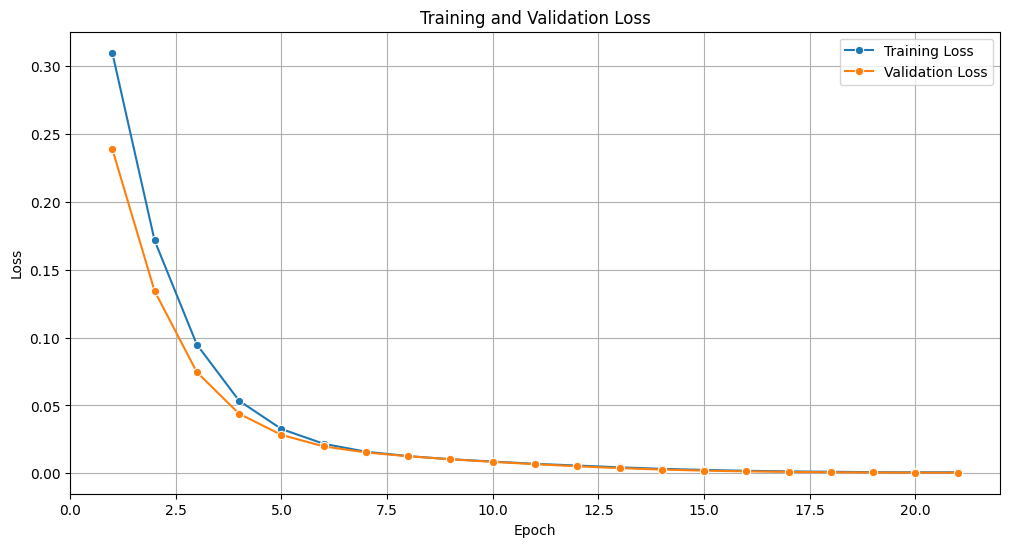

In [27]:
# plot the training and validation loss
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, executed_epochs + 1), y=train_loss_list, label='Training Loss', marker='o')
sns.lineplot(x=range(1, executed_epochs + 1), y=valid_loss_list, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

We can use the loss (average loss value? or the per-step loss value) as the $f(s_t, a_t)$ for the reward function

We save the model for future uses (demo in RL environment)

In [28]:
# save the trained model

model_save_path = Path("model_trained", f"h_network_{datetime.today().strftime('%Y%m%d')}.pth")
model_save_path.parent.mkdir(parents=True)  # ensure the directory exists

torch.save(h_network.state_dict(), model_save_path)

also save the trained scaler

In [29]:
scaler_train_path = Path("model_trained", f"h_network_standardscaler_{datetime.today().strftime('%Y%m%d')}.pkl")

import joblib
joblib.dump(scaler_train, scaler_train_path)

['model_trained/h_network_standardscaler_20250707.pkl']